## Classification of Toxic Comments

Discussing things you care about can be difficult on online social platforms. The threat of abuse and harassment online means that many people stop expressing themselves and give up on seeking different opinions. The performance of a model for predicting such toxic comments depends on the distribution of data used to train the model. In this notebook, a multi-headed bidirectional LSTM RNN model is developed that’s capable of detecting different types of toxicity like threats, obscenity, insults, and identity-based hate. The model is trained and validated using a dataset of comments from Wikipedia’s talk page edits. The labeled dataset is available on <a href="https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data">kaggle</a>. Moreover, I use the pretrained GloVe word vectors from <a href="http://nlp.stanford.edu/data/glove.6B.zip">Stanford</a>. 

In [1]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


In [2]:
# Define parameters
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 5

In [3]:
# load in pre-trained word vectors
word2vec = {}
with open('glove.6B/glove.6B.50d.txt', encoding="utf8") as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Found 400000 word vectors.


In [4]:
# prepare text samples and their labels
train = pd.read_csv("train.csv/train.csv")
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values

In [5]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [6]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 210337 unique tokens.


In [7]:
# pad sequences so to get same dimnsions N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (159571, 100)


In [8]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [9]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings unchanged/fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

In [10]:
# create an LSTM network with a single LSTM
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
output = Dense(len(possible_labels), activation="sigmoid")(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.01),
  metrics=['accuracy']
)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 127656 samples, validate on 31915 samples
Epoch 1/5
127656/127656 [==============================] - 177s 1ms/step - loss: 0.0735 - acc: 0.9752 - val_loss: 0.0573 - val_acc: 0.9802
Epoch 2/5
127656/127656 [==============================] - 174s 1ms/step - loss: 0.0573 - acc: 0.9799 - val_loss: 0.0546 - val_acc: 0.9806
Epoch 3/5
127656/127656 [==============================] - 179s 1ms/step - loss: 0.0547 - acc: 0.9805 - val_loss: 0.0537 - val_acc: 0.9809
Epoch 4/5
127656/127656 [==============================] - 201s 2ms/step - loss: 0.0531 - acc: 0.9812 - val_loss: 0.0520 - val_acc: 0.9814
Epoch 5/5
127656/127656 [==============================] - 192s 2ms/step - loss: 0.0521 - acc: 0.9814 - val_loss: 0.0514 - val_acc: 0.9816


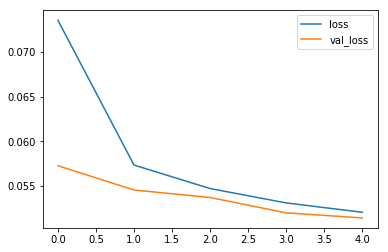

In [12]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

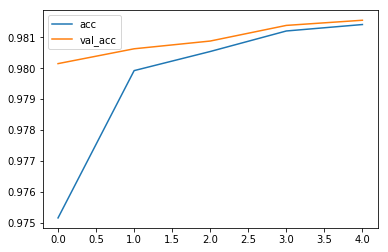

In [13]:
# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [14]:
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.9787805934225066
